In [35]:
import cv2
import torch
import ultralytics
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
from ultralytics import YOLO
import pydicom

saggital_t1_model = YOLO("models/best_sagt1_yolo.pt")
saggital_t2_model = YOLO("models/best_sagt2_yolo.pt")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

saggital_t1_model = saggital_t1_model.to(device)
saggital_t2_model = saggital_t2_model.to(device)

names = saggital_t2_model.names
print(names)
from tqdm import tqdm
import os
from glob import glob


    

{0: 'L1-L2', 1: 'L2-L3', 2: 'L3-L4', 3: 'L4-L5', 4: 'L5-S1'}


In [36]:
import cv2
import pydicom
import os
import glob
import json

def get_crops_study_id(study_id, root_folder, output_root="temp/yolo_output"):
    # Remove previous files
    if os.path.exists(f"{output_root}"):
        os.system(f"rm -rf {output_root}")
    
    os.makedirs(f"{output_root}")
    os.makedirs(f"{output_root}/sagittal_t1_jpg")
    os.makedirs(f"{output_root}/sagittal_t2_jpg")
    os.makedirs(f"{output_root}/sagittal_t1_bbox")  # New folder for T1 bbox images
    os.makedirs(f"{output_root}/sagittal_t2_bbox")  # New folder for T2 bbox images

    sag_t1 = glob.glob(f"{root_folder}/{study_id}/sagittal_t1/*.dcm")
    sag_t2 = glob.glob(f"{root_folder}/{study_id}/Sagittal_T2_STIR/*.dcm")

    # Convert DICOM to JPG
    for i, path in enumerate(sag_t1):
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        cv2.imwrite(f"{output_root}/sagittal_t1_jpg/{i}.jpg", image)
    
    for i, path in enumerate(sag_t2):
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        cv2.imwrite(f"{output_root}/sagittal_t2_jpg/{i}.jpg", image)

    sag_t1 = glob.glob(f"{output_root}/sagittal_t1_jpg/*.jpg") 
    sag_t2 = glob.glob(f"{output_root}/sagittal_t2_jpg/*.jpg")

    print(f"Processing study {study_id}")

    bbox_info ={}

    # Process Sagittal T1 images
    for i, img_path in enumerate(sag_t1):
        pred = saggital_t1_model(img_path, conf=0.3)
        for x in pred:
            confidence = x.boxes.conf.cpu().numpy()
            if len(confidence) > 1:
                for box in x.boxes:
                    confidence = float(box.conf.cpu().numpy()[0])
                    cls = names[box.cls.cpu().numpy()[0]]
                    coordinates = box.xyxy.cpu().numpy()[0]

                    key = f"sag_t1_{cls}"
                    

                    
                    # Read image
                    image = cv2.imread(img_path)

                    # Draw bounding box
                    cv2.rectangle(image, 
                                  (int(coordinates[0]), int(coordinates[1])), 
                                  (int(coordinates[2]), int(coordinates[3])), 
                                  (0, 255, 0), 2)
                    
                    # Save the image with bounding boxes
                    bbox_folder = f"{output_root}/sagittal_t1_bbox/{cls}"
                    os.makedirs(bbox_folder, exist_ok=True)
                    #ex image path - /home/arushthegarlic/RSNA-MSCAN/temp/yolo_output/sagittal_t2_jpg/4.jpg 
                    im_index = img_path.split("/")[-1].split(".")[0]
                    cv2.imwrite(f"{bbox_folder}/{im_index}_conf_{confidence:.2f}_bbox.jpg", image)

                    # Crop and save the detected region
                    crop = image[int(coordinates[1]):int(coordinates[3]), int(coordinates[0]):int(coordinates[2])]
                    crop_folder = f"{output_root}/sagittal_t1/{cls}"
                    os.makedirs(crop_folder, exist_ok=True)
                    cv2.imwrite(f"{crop_folder}/{im_index}_conf_{confidence:.2f}.jpg", crop)

                    if key not in bbox_info:
                        bbox_info[key] = []
                    bbox_info[key].append({
                    "image_path": f"{crop_folder}/{im_index}_conf_{confidence:.2f}.jpg" ,
                    "confidence": confidence,
                    "bbox": coordinates.tolist(),
                    "img_idx": im_index
                })


    # Process Sagittal T2 images
    for i, img_path in enumerate(sag_t2):
        pred = saggital_t2_model(img_path, conf=0.3)
        for x in pred:
            confidence = x.boxes.conf.cpu().numpy()
            if len(confidence) > 1:
                for box in x.boxes:
                    im_index = img_path.split("/")[-1].split(".")[0]
                    confidence = float(box.conf.cpu().numpy()[0])
                    cls = names[box.cls.cpu().numpy()[0]]
                    coordinates = box.xyxy.cpu().numpy()[0]
                    
                    key = f"sag_t2_{cls}"
                    
                    
                    # Read image
                    image = cv2.imread(img_path)



                    # Crop and save the detected region
                    crop = image[int(coordinates[1]):int(coordinates[3]), int(coordinates[0]):int(coordinates[2])]
                    crop_folder = f"{output_root}/sagittal_t2/{cls}"
                    os.makedirs(crop_folder, exist_ok=True)
                    cv2.imwrite(f"{crop_folder}/{im_index}_conf_{confidence:.2f}.jpg", crop)


                                        # Draw bounding box
                    cv2.rectangle(image, 
                                  (int(coordinates[0]), int(coordinates[1])), 
                                  (int(coordinates[2]), int(coordinates[3])), 
                                  (0, 255, 0), 2)

                    # Save the image with bounding boxes
                    bbox_folder = f"{output_root}/sagittal_t2_bbox/{cls}"
                    os.makedirs(bbox_folder, exist_ok=True)
                    cv2.imwrite(f"{bbox_folder}/{im_index}_conf_{confidence:.2f}_bbox.jpg", image)

                    if key not in bbox_info:
                        bbox_info[key] = []
                    bbox_info[key].append({"image_path": f"{crop_folder}/{im_index}_conf_{confidence:.2f}.jpg", "confidence": confidence, "bbox": coordinates.tolist(), "img_idx": im_index})

    json_file_path = f"{output_root}/bbox_info.json"
    with open(json_file_path, "w") as f:
        json.dump(bbox_info, f, indent=4)
    print(f"Saved bounding box info to {json_file_path}")


In [37]:
import sys, os
import matplotlib
import matplotlib.pyplot as plt

from pointnet.helper import *
from pointnet.data import *
from pointnet.model import *

cfg=dotdict(
    point_net=dotdict(
        checkpoint='pointnet/00002484.pth',
        image_size=160,
    ),
)


level_to_label={
    'l1_l2':1,
    'l2_l3':2,
    'l3_l4':3,
    'l4_l5':4,
    'l5_s1':5,
}

point_net = Net(pretrained=True)
f = torch.load(cfg.point_net.checkpoint, map_location=lambda storage, loc: storage)
state_dict = f['state_dict']
print(point_net.load_state_dict(state_dict, strict=False))
point_net.cuda()
point_net.eval()
point_net.output_type = ['infer']

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet50d.ra2_in1k)
INFO:timm.models._hub:[timm/resnet50d.ra2_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.


<All keys matched successfully>


In [38]:
def read_series_folder(root_folder , study_id,series_id,series_description):
	dicom_dir = f'{root_folder}/{study_id}/{series_id}'

	# read dicom file
	dicom_file = natsorted(glob.glob(f'{dicom_dir}/*.dcm'))
	#instance_number = [int(f.split('/')[-1].split('.')[0]) for f in dicom_file]
	#For windowa - 
	instance_number = [int(f.split('/')[-1].split('\\')[0].split('.')[0]) for f in dicom_file]
	dicom = [pydicom.dcmread(f) for f in dicom_file]

	# make dicom header df
	H, W = dicom[0].pixel_array.shape
	dicom_df = []
	for i, d in zip(instance_number, dicom):  # d__.dict__
		dicom_df.append(
			dotdict(
				study_id=study_id,
				series_id=series_id,
				series_description=series_description,
				instance_number=i,
				# InstanceNumber = d.InstanceNumber,
				ImagePositionPatient=[float(v) for v in d.ImagePositionPatient],
				ImageOrientationPatient=[float(v) for v in d.ImageOrientationPatient],
				PixelSpacing=[float(v) for v in d.PixelSpacing],
				SpacingBetweenSlices=float(d.SpacingBetweenSlices),
				SliceThickness=float(d.SliceThickness),
				grouping=str([round(float(v), 3) for v in d.ImageOrientationPatient]),
				H=H,
				W=W,
			)
		)
	dicom_df = pd.DataFrame(dicom_df)

	# sort slices
	dicom_df = [d for _, d in dicom_df.groupby('grouping')]

	data = []
	sort_data_by_group = []
	for df in dicom_df:
		position = np.array(df['ImagePositionPatient'].values.tolist())
		orientation = np.array(df['ImageOrientationPatient'].values.tolist())
		normal = np.cross(orientation[:, :3], orientation[:, 3:])
		projection = np_dot(normal, position)
		df.loc[:, 'projection'] = projection
		df = df.sort_values('projection')


		# todo: assert all slices are continous ??
		# use  (position[-1]-position[0])/N = SpacingBetweenSlices ??
		assert len(df.SliceThickness.unique()) == 1
		assert len(df.SpacingBetweenSlices.unique()) == 1


		volume = [
			dicom[instance_number.index(i)].pixel_array for i in df.instance_number
		]
		volume = np.stack(volume)
		volume = normalise_to_8bit(volume)
		data.append(dotdict(
			df=df,
			volume=volume,
		))

		if 'sagittal' in series_description.lower():
			sort_data_by_group.append(position[0, 0])  # x
		if 'axial' in series_description.lower():
			sort_data_by_group.append(position[0, 2])  # z

	data = [r for _, r in sorted(zip(sort_data_by_group, data))]
	for i, r in enumerate(data):
		r.df.loc[:, 'group'] = i

	df = pd.concat([r.df for r in data])
	df.loc[:, 'z'] = np.arange(len(df))
	volume = np.concatenate([r.volume for r in data])
	data = dotdict(
		series_id=series_id,
		df=df,
		volume=volume,
	)
	return data


# def read_study(study_id, sagittal_t2_id, axial_t2_id):
# 	return dotdict(
# 		study_id = study_id,
# 		sagittal_t2 =read_series(study_id, sagittal_t2_id, 'sagittal_t2'),
# 		axial_t2 =read_series(study_id, axial_t2_id, 'axial_t2'),
# 	)

In [39]:
def imread_and_imwirte(src_path, dst_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    img = cv2.resize(image, (512, 512),interpolation=cv2.INTER_CUBIC)
    assert img.shape==(512,512)
    cv2.imwrite(dst_path, img)

In [40]:
def Axial_levels(study_id, root_folder, output_root="temp/axial_output"):
    data = dotdict(
        study_id=study_id,
        sagittal_t2=read_series_folder(root_folder, study_id, 'Sagittal_T2_STIR', 'sagittal_t2'),
        axial_t2=read_series_folder(root_folder, study_id, 'Axial_T2', 'axial_t2'),
    )

    # Remove previous files
    if os.path.exists(f"{output_root}"):
        os.system(f"rm -rf {output_root}")

    os.makedirs(f"{output_root}")


    
    print(f"Processing study {study_id}")

    sagittal_t2 = data.sagittal_t2.volume
    sagittal_t2_df = data.sagittal_t2.df
    axial_t2_df = data.axial_t2.df

    D,H,W = sagittal_t2.shape
    image = resize_volume(sagittal_t2,cfg.point_net.image_size)

    sagittal_t2_z = D//2
    image = image[sagittal_t2_z] #we use only center image #todo: better selection
    print(image.shape)
    batch = dotdict(
        sagittal=torch.from_numpy(image).unsqueeze(0).unsqueeze(0).byte()
    )
    with torch.cuda.amp.autocast(enabled=True):
        with torch.no_grad():
            output = point_net(batch)

    probability = output['probability'][0].float().data.cpu().numpy()
    sagittal_t2_point = probability_to_point(probability) #5 level 2d points, todo: check invalid output point

    # #for debug and development
    # point_hat, z_hat = sagittal_t2_point_hat = get_true_sagittal_t2_point(study_id, sagittal_t2_df)
    # point_hat = point_hat*[[cfg.point_net.image_size/W, cfg.point_net.image_size/H]]


    #--- step.2 : perdict slice level of axial_t2
    world_point = world_point = view_to_world(sagittal_t2_point, sagittal_t2_z, sagittal_t2_df, cfg.point_net.image_size)
    assigned_level, closest_z, dis  = axial_t2_level = point_to_level(world_point, axial_t2_df)
    print('assigned_level:', assigned_level)

    #--- step.3 : save output
    fig = plt.figure(figsize=(23, 6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')

    # detection result
    p = probability_to_rgb(probability)
    m = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    m = 255 - (255 - m * 0.8) * (1 - p / 255)

    ax1.imshow(m / 255)
    ax1.set_title(f'sagittal keypoint detection (unet)')


    # draw  assigned_level
    level_ncolor = np.array(level_color) / 255
    coloring = level_ncolor[assigned_level].tolist()
    draw_slice(
        ax2, axial_t2_df,
        is_slice=True,   scolor=coloring, salpha=[0.1],
        is_border=True,  bcolor=coloring, balpha=[0.2],
        is_origin=False, ocolor=[[0, 0, 0]], oalpha=[0.0],
        is_arrow=True
    )

    # draw world_point
    #ax2.scatter(world_point[:, 0], world_point[:, 1], world_point[:, 2], alpha=1, color='black')


    ### draw closest slice
    coloring = level_ncolor[1:].tolist()
    draw_slice(
        ax2, axial_t2_df.iloc[closest_z],
        is_slice=True, scolor=coloring, salpha=[0.1],
        is_border=True, bcolor=coloring, balpha=[1],
        is_origin=False, ocolor=[[1, 0, 0]], oalpha=[0],
        is_arrow=False
    )

    ax2.set_aspect('equal')
    ax2.set_title(f'axial slice assignment\n ')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_zlabel('z')
    ax2.view_init(elev=0, azim=-10, roll=0)
    plt.tight_layout(pad=2)
    plt.savefig(f"{output_root}/axial_levels.png" , bbox_inches='tight')


    instance_no = axial_t2_df.iloc[closest_z]['instance_number'].values
    l1_l2 = instance_no[0]
    l2_l3 = instance_no[1]
    l3_l4 = instance_no[2]
    l4_l5 = instance_no[3]
    l5_s1 = instance_no[4]



    #Save as -2, -1, 0, 1, 2

    main_path = root_folder + "/" + study_id + "/Axial_T2"
    #Save in axial_levels_2/study_id/L1_L2
    if not os.path.exists(output_root + "/axial_levels_2"):
        os.makedirs(output_root + "/axial_levels_2")
    if not os.path.exists(output_root + "/axial_levels_2/L1_L2"):
        os.makedirs(output_root + "/axial_levels_2/L1_L2")
    if not os.path.exists(output_root + "/axial_levels_2/L2_L3"):
        os.makedirs(output_root + "/axial_levels_2/L2_L3")
    if not os.path.exists(output_root + "/axial_levels_2/L3_L4"):
        os.makedirs(output_root + "/axial_levels_2/L3_L4")
    if not os.path.exists(output_root + "/axial_levels_2/L4_L5"):
        os.makedirs(output_root + "/axial_levels_2/L4_L5")
    if not os.path.exists(output_root + "/axial_levels_2/L5_S1"):
        os.makedirs(output_root + "/axial_levels_2/L5_S1")


        
    #l1_l2
    dcm_path = main_path + "/" 
    #If increasing then save as -2, -1, 0, 1, 2 else save as 2, 1, 0, -1, -2

    #l1_l2 +2 and -2
    for i in range(5):
        try:
            
            save_path = output_root + "/axial_levels_2/"+ "/L1_L2/" + str(i-2) + ".png"
            impath = dcm_path + str(l1_l2 + i - 2) + ".dcm"
            imread_and_imwirte(impath, save_path)
        except:
            pass

    #l2_l3
    dcm_path = main_path + "/"
    for i in range(5):
        try:
            save_path =  output_root + "/axial_levels_2/"+ "/L2_L3/" + str(i-2) + ".png"
            impath = dcm_path + str(l2_l3 + i - 2) + ".dcm"
            imread_and_imwirte(impath, save_path)
        except Exception as e:
            print(e)
            pass

    #l3_l4
    dcm_path = main_path + "/"
    for i in range(5):
        try:
            save_path =  output_root + "/axial_levels_2/"+ "/L3_L4/" + str(i-2) + ".png"
            impath = dcm_path + str(l3_l4 + i - 2) + ".dcm"
            imread_and_imwirte(impath, save_path)
        except Exception as e:
            print(e)
            pass

    #l4_l5
    dcm_path = main_path + "/"
    for i in range(5):
        try:
            save_path = output_root + "/axial_levels_2/"+ "/L4_L5/" + str(i-2) + ".png"
            impath = dcm_path + str(l4_l5 + i - 2) + ".dcm"
            imread_and_imwirte(impath, save_path)
        except:
            pass

    #l5_s1
    dcm_path = main_path + "/"
    for i in range(5):
        try:
            save_path =  output_root + "/axial_levels_2/"+ "/L5_S1/" + str(i-2) + ".png"
            impath = dcm_path + str(l5_s1 + i - 2) + ".dcm"
            imread_and_imwirte(impath, save_path)
        except:
                pass




In [41]:
import timm
import torch.nn as nn
from itertools import repeat

class SpatialDropout(nn.Module):
    def __init__(self, drop=0.5):
        super(SpatialDropout, self).__init__()
        self.drop = drop
        
    def forward(self, inputs, noise_shape=None):
        """
        @param: inputs, tensor
        @param: noise_shape, tuple
        """
        outputs = inputs.clone()
        if noise_shape is None:
            noise_shape = (inputs.shape[0], *repeat(1, inputs.dim()-2), inputs.shape[-1]) 
        
        self.noise_shape = noise_shape
        if not self.training or self.drop == 0:
            return inputs
        else:
            noises = self._make_noises(inputs)
            if self.drop == 1:
                noises.fill_(0.0)
            else:
                noises.bernoulli_(1 - self.drop).div_(1 - self.drop)
            noises = noises.expand_as(inputs)    
            outputs.mul_(noises)
            return outputs
            
    def _make_noises(self, inputs):
        return inputs.new().resize_(self.noise_shape)


import torch
from torch import nn
import torch.nn.functional as F

from typing import Dict, Optional
 
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor



class CFG:

    model_arch= 'efficientnetv2_rw_t.ra2_in1k'
    img_size=400
    seq_len = 24
    dropout=0.1
    multihead=False


class MLPAttentionNetwork(nn.Module):
 
    def __init__(self, hidden_dim, attention_dim=None):
        super(MLPAttentionNetwork, self).__init__()
 
        self.hidden_dim = hidden_dim
        self.attention_dim = attention_dim
        if self.attention_dim is None:
            self.attention_dim = self.hidden_dim

        # W * x + b
        self.proj_w = nn.Linear(self.hidden_dim, self.attention_dim, bias=True)
        # v.T
        self.proj_v = nn.Linear(self.attention_dim, 1, bias=False)
 
    def forward(self, x):
        """
        :param x: seq_len, batch_size, hidden_dim
        :return: batch_size * seq_len, batch_size * hidden_dim
        """
        # print(f"x shape:{x.shape}")
        batch_size, seq_len, _ = x.size()
        # flat_inputs = x.reshape(-1, self.hidden_dim) # (batch_size*seq_len, hidden_dim)
        # print(f"flat_inputs shape:{flat_inputs.shape}")
        
        H = torch.tanh(self.proj_w(x)) # (batch_size, seq_len, hidden_dim)
        # print(f"H shape:{H.shape}")
        
        att_scores = torch.softmax(self.proj_v(H),axis=1) # (batch_size, seq_len)
        # print(f"att_scores shape:{att_scores.shape}")
        
        attn_x = (x * att_scores).sum(1) # (batch_size, hidden_dim)
        # print(f"attn_x shape:{attn_x.shape}")
        return attn_x
    

class RSNAClassifier(nn.Module):
    def __init__(self, model_arch, hidden_dim=256, seq_len=24, pretrained=False):
        super().__init__()
        self.seq_len = seq_len
        self.model = timm.create_model(model_arch, in_chans=1, pretrained=pretrained , num_classes=3)
        # self.model.load_state_dict(torch.load('Sag_PreTrain.pth'))

        self.model_ax   = timm.create_model(model_arch, in_chans=1, pretrained=pretrained , num_classes=3)
        # self.model_ax.load_state_dict(torch.load('unet_axial_main.pt', weights_only=True))

        #freeze
        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model_ax.parameters():
            param.requires_grad = False

        if 'efficientnet' in CFG.model_arch:
            cnn_feature = self.model.classifier.in_features
            self.model.classifier = nn.Linear(cnn_feature, 512)
            
            self.model_ax.classifier = nn.Linear(cnn_feature, 512)
            
        elif "res" in CFG.model_arch:
            cnn_feature = self.model.fc.in_features
            self.model.global_pool = nn.Identity()
            self.model.fc = nn.Identity()
            self.pooling = nn.AdaptiveAvgPool2d(1)

        
        self.spatialdropout = SpatialDropout(0.1)

        self.lstm_out = nn.GRU(512, 256, 2, batch_first=True, bidirectional=True)
        self.lstm_out_ax = nn.GRU(512, 256, 2, batch_first=True, bidirectional=True)
        self.fc = nn.Linear( 1024, 15)
        self.cross_attn = nn.MultiheadAttention(embed_dim=512, num_heads=2)
        self.cross_attn_2 = nn.MultiheadAttention(embed_dim=512, num_heads=2)
        self.lstm_ax = nn.LSTM(512, 256, 2, batch_first=True, bidirectional=True)       

        




    def forward(self, z): # (B, seq_len, H, W)
        #(bs , vertebrae , slices ,  H , W)
        x = z['saggital']
        ax = z['axial']
        bs = x.size(0)
        x = x.reshape(bs*self.seq_len, 1, 384, 384) # (B*seq_len, 1, H, W)
        embeds = self.model(x) 
        embeds = embeds.reshape(bs, self.seq_len, -1)       # (B, seq_len, cnn_feature)
        out, _ = self.lstm_out(embeds)
        ax = ax.reshape(bs*self.seq_len*3, 1, 384, 384)
        embeds_ax = self.model_ax(ax)
        embed_axial = torch.zeros(bs, self.seq_len, 512).to('cuda')
        for i in range(self.seq_len):
            embed_axial[:,i,:] = self.lstm_ax(embeds_ax[i*3:i*3+3].unsqueeze(0))[0][:,-1,:]

        out_ax, _ = self.lstm_out_ax(embed_axial)
        #out = torch.cat((out, out_ax),1)

        out1 ,_ = self.cross_attn(out_ax, out, out)

        out2 ,_ = self.cross_attn_2(out, out_ax, out_ax)
        out1 = out1[:,-1,:]
        out2 = out2[:,-1,:]
        out2 = self.spatialdropout(out2)
        out1 = self.spatialdropout(out1)

        out = torch.cat((out1, out2),1)


        out = self.fc(out)
        return out



In [42]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from PIL import Image


model_nmae = 'resnet18'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cord = timm.create_model(model_nmae, pretrained=True , in_chans = 1  , num_classes=2).to(device)
model_cord.load_state_dict(torch.load('models/unet_axial.pt', weights_only=True))

def get_data( sagt2_dir, axial_dir , transform=None):

    saggital = np.zeros(( 384, 384,5), dtype=np.float32)

    main_sag_dir = f"{sagt2_dir}/"

    levels = os.listdir(main_sag_dir )
    #Sort
    levels = sorted(levels, key=lambda x: x.split("-")[0][1])
    clahe = A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), always_apply=True)

    for i, level in enumerate(levels):
        try:
            #Open middle image
            l = os.listdir(main_sag_dir + level)
            #Sort on the basis of image name
            #Average of all images
            img = np.zeros((384,384), dtype=np.float32)
            for img_sag in l:
                pth = main_sag_dir + level + "/" + img_sag
                img_temp = Image.open(pth).convert('L')
                #Resize
                img_temp = cv2.resize(np.array(img_temp), (384, 384))
                img_temp = np.array(img_temp)
                img += img_temp
            img = img/len(l)
            
            
            
            
            saggital[:,:,i] = img
        except Exception as e:
            print(e)
            continue
    
    
    axial = np.zeros((384,384,3,5), dtype=np.float32)
    main_axial_dir = f"{axial_dir}/"
    levels = os.listdir(main_axial_dir)
    
    for i, level in enumerate(levels):
        l = os.listdir(main_axial_dir + level)
        l = sorted(l, key=lambda x: int(x.split(".")[0]))
        if len(l) < 3:
            #Repeat 0th image
            l = [l[0]]*3
        else:
            l = l[len(l)//2-1:len(l)//2+2]
        for j, img_ax in enumerate(l):
            pth = main_axial_dir + level + "/" + img_ax
            img = Image.open(pth).convert('L')
            #img = clahe(image=np.array(img))['image']
            img = np.array(img)

            img = cv2.resize(img, (384, 384))
            img = torch.tensor(img).float()
            img = img.unsqueeze(0)

            # print (img.shape)
            pred = model_cord(img.unsqueeze(0).to(device))
            pred = pred.cpu().detach().numpy()
            # print (pred)
            x=pred[0][0]
            y=pred[0][1]
            #crop image 0.25 around the predicted point
            img = img.squeeze().cpu().numpy()

            img = img[int(y*384)-80:int(y*384)+80, int(x*384)-80:int(x*384)+80]
            img = cv2.resize(img, (384, 384))

            axial[:,:,j,i] = img

    

    if transform:
        x = transform(image=saggital)['image']
        for i in range(5):
            for j in range(3):
                img = axial[:,:,j,i]
                img = transform(image=img)['image']
                axial[:,:,j,i] = img

    x = torch.tensor(saggital).float()    
    x = x.permute(2,0,1)
    axial = torch.tensor(axial).float()
    axial = axial.permute(3,2,0,1)


    return {'saggital': x, 'axial': axial}


transforms_val = A.Compose([

    A.Normalize(mean=0.5, std=0.5),
])



INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (timm/resnet18.a1_in1k)
INFO:timm.models._hub:[timm/resnet18.a1_in1k] Safe alternative available for 'pytorch_model.bin' (as 'model.safetensors'). Loading weights using safetensors.
INFO:timm.models._builder:Converted input conv conv1 pretrained weights from 3 to 1 channel(s)
INFO:timm.models._builder:Missing keys (fc.weight, fc.bias) discovered while loading pretrained weights. This is expected if model is being adapted.


## Final Function


In [43]:
model = RSNAClassifier(CFG.model_arch, hidden_dim=256, seq_len=5, pretrained=False)
model.load_state_dict(torch.load('models/best_acc_model_fold-.pt', map_location=device))
model.eval()


RSNAClassifier(
  (model): EfficientNet(
    (conv_stem): Conv2d(1, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
      

In [44]:
study_id = "41477684"


Processing study 41477684
(160, 160)
assigned_level: [5 5 5 5 5 4 4 4 4 4 4 3 3 3 3 3 3 2 2 2 2 2 1 1 1 1 1]


/tmp/ipykernel_45671/2243688009.py:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=True):


torch.Size([1, 5, 384, 384])
torch.Size([1, 5, 3, 384, 384])
tensor([[ 3.3281, -0.6616, -4.0656,  0.7321,  0.8764, -2.6465, -2.4460,  0.5131,  1.5202, -1.3672, -0.5088,  1.1835,  2.8628, -0.7174, -3.3282]], device='cuda:0')
Level 1 : 0
Level 2 : 1
Level 3 : 2
Level 4 : 2
Level 5 : 0


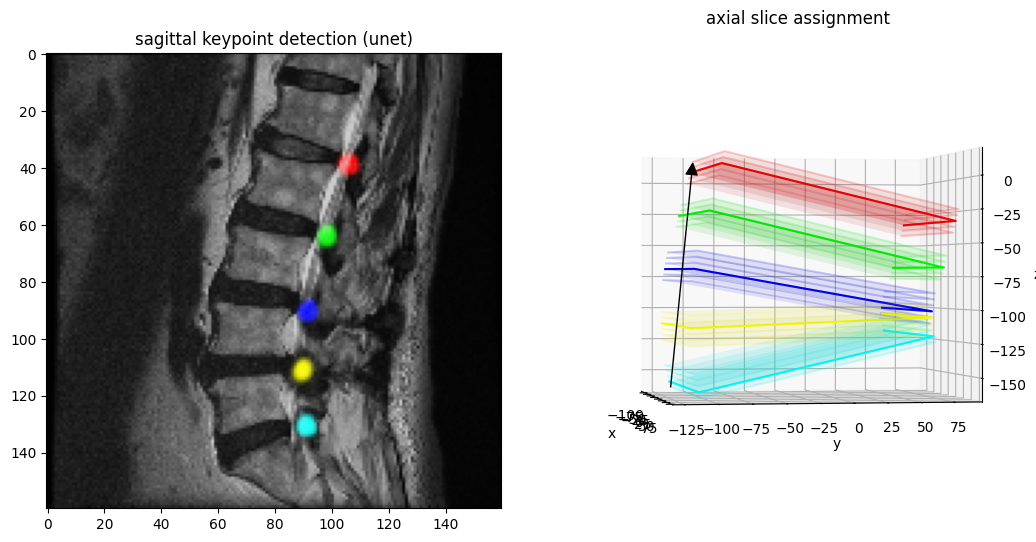

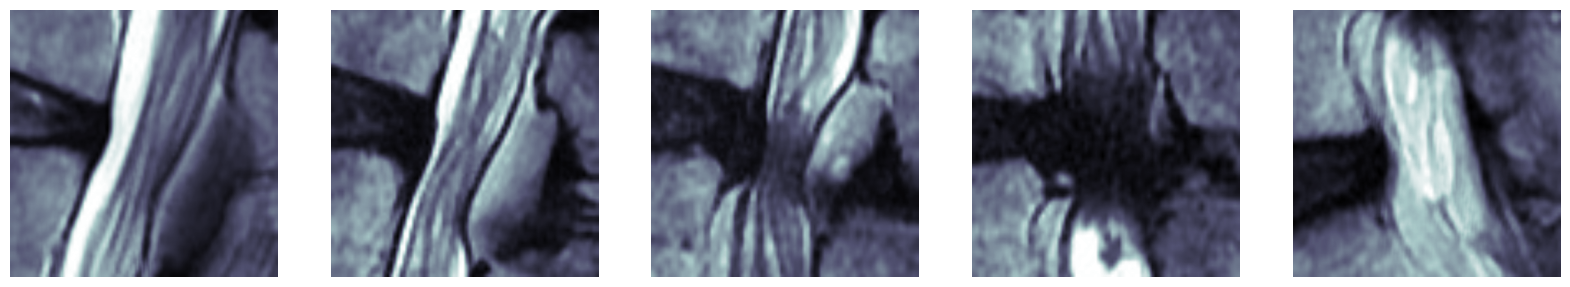

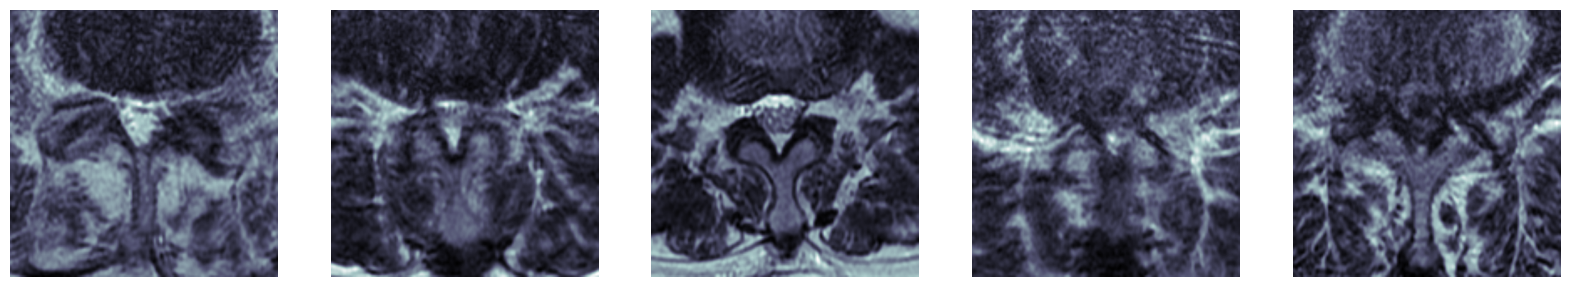

In [45]:
get_crops_study_id(study_id, "sample_test_cases", "temp/yolo_output")
clear_output()
Axial_levels(study_id, "sample_test_cases", "temp/axial_output")
#Predict


data  = get_data("temp/yolo_output/sagittal_t2", "temp/axial_output/axial_levels_2", transforms_val)
model = model.eval()
model = model.to(device)
with torch.no_grad():
    data = {k: v.unsqueeze(0).to(device) for k, v in data.items()}
    print(data['saggital'].shape)
    print(data['axial'].shape)
    output = model(data)
    print(output)
    for i in range(5):
        print(f"Level {i+1} : {torch.argmax(output[0][i*3:i*3+3])}")
        
data  = get_data("temp/yolo_output/sagittal_t2", "temp/axial_output/axial_levels_2", transforms_val)

#Plot 
idx =45
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(data['saggital'][i], cmap='bone')
    ax[i].axis('off')

plt.show()

fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    ax[i].imshow(data['axial'][i][1], cmap='bone')
    ax[i].axis('off')

plt.show()

In [46]:
import json
import torch
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import os

def create_vertebra_image(abnormalities):

    images = []
    labels = []
    
    for abnormal in abnormalities:
        for key, img_path in abnormal.items():
            try:
                img = Image.open(img_path).convert("RGB")
                images.append(img)
                labels.append(key)
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    if not images:
        print("No images found to concatenate.")
        return None, None

    # Resize all images to the same width keeping aspect ratio
    max_width = max(img.width for img in images)
    total_height = sum(img.height for img in images) + (20 * len(images))  
    
    concatenated_img = Image.new("RGB", (max_width, total_height), "white")

    y_offset = 0
    draw = ImageDraw.Draw(concatenated_img)
    font = ImageFont.load_default() 

    for img, label in zip(images, labels): 
        concatenated_img.paste(img, (0, y_offset))
        draw.text((10, y_offset + img.height + 5), label, fill="black", font=font)
        y_offset += img.height + 20  

    output_path = "temp/vertebra_report.jpg"
    concatenated_img.save(output_path)
    return output_path, labels

    
abnormalities = []
abnormal_coordinates = {}
def print_vertebra_report(classifier_output, bbox_json_path,abnormalities, abnormal_coordinates):
    abnormal_coordinates["moderate"] = []
    abnormal_coordinates["severe"] = []
    with open(bbox_json_path, "r") as f:
        bbox_info = json.load(f)

    severity_mapping = {0: "normal/mild", 1: "moderate", 2: "severe"}
    vertebra_order = ["L1-L2", "L2-L3", "L3-L4", "L4-L5", "L5-S1"]
    vertebra_modality_keys = {
        "L1-L2": ["sag_t2_L1-L2", "sag_t1_L1-L2"],
        "L2-L3": ["sag_t2_L2-L3", "sag_t1_L2-L3"],
        "L3-L4": ["sag_t2_L3-L4", "sag_t1_L3-L4"],
        "L4-L5": ["sag_t2_L4-L5", "sag_t1_L4-L5"],
        "L5-S1": ["sag_t2_L5-S1", "sag_t1_L5-S1"],
    }
    gpt_prompt = "Our model is predicting the following spinal canal stenosis severity levels for each vertebra:\n\n"

    
    

    for i, level in enumerate(vertebra_order):
        level_slice = classifier_output[0][i * 3 : i * 3 + 3]
        severity_idx = int(torch.argmax(level_slice).item()) if level_slice.numel() > 0 else -1
        severity_str = severity_mapping.get(severity_idx, "404")

        detections = []
        for key in vertebra_modality_keys[level]:
            if key in bbox_info and len(bbox_info[key]) > 0:
                detections.extend(bbox_info[key])

        if detections:
            best_detection = sorted(detections, key=lambda x: x["confidence"], reverse=True)[0]
            image_path = best_detection.get("image_path", next((v for k, v in best_detection.items() if k not in ["confidence", "bbox", "img_idx"]), "Path not available"))
            coordinates= best_detection.get("bbox", "Coordinates not available")
        else:
            image_path = "No detection found"

        # print(f"{level}: {severity_str} - path is {image_path}")
        gpt_prompt += f"- **{level}**: {severity_str.capitalize()} \n"

        if severity_str in ["moderate", "severe"]:
            abnormalities.append({f"{level}_{severity_str}": image_path})
            if severity_str == "moderate":
                abnormal_coordinates["moderate"].append(coordinates)
            else:
                abnormal_coordinates["severe"].append(coordinates)
    
        

    image_path, labels = create_vertebra_image(abnormalities)
    gpt_prompt = gpt_prompt + "\nPlease generate a detailed radiology report based on the above findings, an image is attached that has the cropped abnormal vertebrae with their respective severity levels, study the image and generate a detailed report in order to explain the models findings."
    # gpt_prompt = generate_gpt_prompt(abnormalities, image_path)

    return image_path, gpt_prompt


bbox_json_path = "temp/yolo_output/bbox_info.json"
image_path, gpt_prompt = print_vertebra_report(output, bbox_json_path,abnormalities,abnormal_coordinates)
print (f"abnormalities are {abnormalities}")
print (f"abnormal_coordinates are {abnormal_coordinates}")
if image_path:
    print("\nConcatenated image saved at:", image_path)
    print("\nGenerated GPT Prompt:\n", gpt_prompt)

#abnormalities are [{'L2-L3_moderate': 'temp/yolo_output/sagittal_t2/L2-L3/4_conf_0.78.jpg'}, {'L3-L4_severe': 'temp/yolo_output/sagittal_t2/L3-L4/4_conf_0.78.jpg'}, {'L4-L5_severe': 'temp/yolo_output/sagittal_t2/L4-L5/4_conf_0.80.jpg'}]
def create_boxes_video(image_folder, abnormal_coordinates, output_image_path="temp/yolo_output/sagittal_t2_video_boxes_jpg"):
    if os.path.exists(output_image_path):
        os.system(f"rm -rf {output_image_path}")
    os.makedirs(output_image_path, exist_ok=True)
    sag_t2 = glob.glob(f"{image_folder}/*.jpg")
    print(sag_t2)
    # ['temp/yolo_output/sagittal_t2_jpg/7.jpg', 'temp/yolo_output/sagittal_t2_jpg/2.jpg', 'temp/yolo_output/sagittal_t2_jpg/12.jpg', 'temp/yolo_output/sagittal_t2_jpg/5.jpg', 'temp/yolo_output/sagittal_t2_jpg/8.jpg', 'temp/yolo_output/sagittal_t2_jpg/6.jpg', 'temp/yolo_output/sagittal_t2_jpg/9.jpg', 'temp/yolo_output/sagittal_t2_jpg/15.jpg', 'temp/yolo_output/sagittal_t2_jpg/0.jpg', 'temp/yolo_output/sagittal_t2_jpg/17.jpg', 'temp/yolo_output/sagittal_t2_jpg/1.jpg', 'temp/yolo_output/sagittal_t2_jpg/3.jpg', 'temp/yolo_output/sagittal_t2_jpg/16.jpg', 'temp/yolo_output/sagittal_t2_jpg/10.jpg', 'temp/yolo_output/sagittal_t2_jpg/11.jpg', 'temp/yolo_output/sagittal_t2_jpg/4.jpg', 'temp/yolo_output/sagittal_t2_jpg/13.jpg', 'temp/yolo_output/sagittal_t2_jpg/14.jpg']

    for img_path in sag_t2:
        im_index = int(img_path.split("/")[-1].split(".")[0])
        img = cv2.imread(img_path)
        # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img_pil = Image.fromarray(img)
        # draw = ImageDraw.Draw(img_pil)
        for i, coordinates in enumerate(abnormal_coordinates["moderate"]):
            x_min, y_min, x_max, y_max = map(int, coordinates)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 255, 0), 3) 

           
        for i, coordinates in enumerate(abnormal_coordinates["severe"]):
            x_min, y_min, x_max, y_max = map(int, coordinates)
            cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 0, 255), 3)
        
        cv2.imwrite(f"{output_image_path}/{im_index}.jpg", img)
        # print(f"Saving image at {output_image_path}/{os.path.basename(img)}")
        # img_pil.save(f"{output_image_path}/{os.path.basename(img)}")

    # print(f"Boxes added to images and saved at {output_image_path}")

create_boxes_video("temp/yolo_output/sagittal_t2_jpg", abnormal_coordinates, "temp/yolo_output/sagittal_t2_video_boxes_jpg")    





abnormalities are [{'L2-L3_moderate': 'temp/yolo_output/sagittal_t2/L2-L3/4_conf_0.78.jpg'}, {'L3-L4_severe': 'temp/yolo_output/sagittal_t2/L3-L4/4_conf_0.78.jpg'}, {'L4-L5_severe': 'temp/yolo_output/sagittal_t2/L4-L5/4_conf_0.80.jpg'}]
abnormal_coordinates are {'moderate': [[272.17822265625, 162.5758514404297, 354.22412109375, 245.0421142578125]], 'severe': [[250.6864776611328, 243.602783203125, 331.072021484375, 324.6653747558594], [246.41006469726562, 314.8738708496094, 327.51202392578125, 395.6729736328125]]}

Concatenated image saved at: temp/vertebra_report.jpg

Generated GPT Prompt:
 Our model is predicting the following spinal canal stenosis severity levels for each vertebra:

- **L1-L2**: Normal/mild 
- **L2-L3**: Moderate 
- **L3-L4**: Severe 
- **L4-L5**: Severe 
- **L5-S1**: Normal/mild 

Please generate a detailed radiology report based on the above findings, an image is attached that has the cropped abnormal vertebrae with their respective severity levels, study the image